In [1]:
! pip install langchain langchain-google-genai langchain-community langgraph python-dotenv faiss-cpu pypdf


  Using cached langchain_google_genai-3.2.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached pypdf-6.4.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)
  Using cached google_ai_generativelanguage-0.9.0-py3-none-any.whl.metadata (10 kB)
Using cached langchain_google_genai-3.2.0-py3-none-any.whl (57 kB)
Using cached filetype-1.2.0-py2.py3-none-any.whl (19 kB)
Using cached google_ai_generativelanguage-0.9.0-py3-none-any.whl (1.4 MB)
Using cached pypdf-6.4.0-py3-none-any.whl (329 kB)

   ---------------------------------------- 0/4 [filetype]
   ---------------------------------------- 0/4 [filetype]
   ---------- ----------------------------- 1/4 [pypdf]
   ---------- ----------------------------- 1/4 [pypdf]
   ---------- ----------------------------- 1/4 [pypdf]
   ---------- ----------------------------- 1/4 [pypdf]
   ---------- ----------------------------- 1/4 [pypdf]
   ---------- ----------------------------- 1/4 [pypdf]
  

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.9.0 which is incompatible.


In [2]:
%pip install "langchain>=0.0.270" langchain-google-genai langchain-community langgraph python-dotenv faiss-cpu pypdf

from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition

Note: you may need to restart the kernel to use updated packages.


c:\Users\yash pandey\Desktop\RAG Based legal chatbot\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
load_dotenv()

True

In [4]:
llm = ChatGoogleGenerativeAI(model='gemini-2.5-pro')

In [6]:
loader = PyPDFLoader("RAG_BASED_LEGAL_ADVISOR.pdf ")
docs = loader.load()

In [7]:
len(docs)

17

In [8]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [9]:
len(chunks)

18

In [12]:
# use a valid embedding model name for Google Generative AI
# Try the model name without the "models/" prefix which is compatible with the current API version.
embeddings = GoogleGenerativeAIEmbeddings(model='gemini-embedding-001')
vector_store = FAISS.from_documents(chunks, embeddings)

In [13]:
vector_store

In [15]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={'k':4})

In [16]:
@tool
def rag_tool(query):

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [17]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)

In [18]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [19]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}

In [20]:
tool_node = ToolNode(tools)

In [21]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

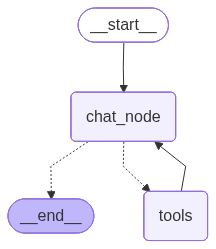

In [22]:
chatbot

In [23]:
result = chatbot.invoke(
    {
        "messages": [
            HumanMessage(
                content=(
                    "Using the pdf notes, explain how to find the ideal value of K in KNN"
                )
            )
        ]
    }
)

In [24]:
print(result['messages'][-1].content)

[{'type': 'text', 'text': 'Based on the document you provided, there is no information on how to find the ideal value of K in KNN. The document describes a RAG-based legal advisor, not the K-Nearest Neighbors algorithm.\n\nHowever, I can tell you about some common methods for finding the ideal value of K in KNN:\n\n**1. The Elbow Method**\n\nThis is a graphical method where you plot the model\'s performance (e.g., error rate or accuracy) for different values of K.\n\n*   For each value of K (e.g., from 1 to 20), you train the KNN model and record the error rate.\n*   You then plot the error rate against the K values.\n*   The plot will typically show the error rate decreasing as K increases. You should look for the "elbow" point, which is the point where the error rate starts to level off. This point is often considered the optimal value for K.\n\n**2. Cross-Validation**\n\nThis is a more robust method for finding the best value of K.\n\n*   You split your training data into a number o